In [54]:
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [55]:
def generate_almost_orthogonal_embeddings(k, D, seed=None):
    rng = np.random.default_rng(seed)
    vecs = rng.normal(size=(k, D))
    # Normalisation
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs.astype(np.float32)


In [56]:
def orthogonality_score(embeddings):
    dot_prods = embeddings @ embeddings.T
    np.fill_diagonal(dot_prods, 0)
    return np.max(np.abs(dot_prods))


In [57]:
R = 20

In [58]:
T = 20
k = 26
D = 1000

In [59]:
embeddings = generate_almost_orthogonal_embeddings(1+k+T, D//2, seed=0)

In [60]:
def generate_dict(k, D):
    assert D % 2 == 0, "D doit être divisible par 2"
    letters = list(string.ascii_uppercase)
    assert k <= len(letters), "k ne doit pas dépasser 26"

    dico = {}

    # Ajout du token 'b' (begin)
    begin_half = embeddings[0]
    begin_vec = np.concatenate([begin_half, np.zeros(D // 2, dtype=np.float32)])
    dico['b'] = begin_vec

    # Ajout des k lettres
    for i in range(k):
        key = letters[i]
        half = embeddings[i + 1]
        vec = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])
        dico[key] = vec

    return dico

In [61]:
dic = generate_dict(k, D)

In [62]:
dic['C'] @ dic['C'].T

1.0

In [63]:
def string_to_token(s):
    return np.array([dic[c] for c in s]).astype(np.float32)

In [64]:
def softmax(x, axis=None):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [65]:

string_seq = ['b', 'C', 'A', 'E', 'C', 'H', 'E', 'A', 'A', 'D', 'B', 'H']
T = len(string_seq)

In [66]:
P = np.zeros((T, D), dtype=np.float32)
for i in range(T):
    half = embeddings[k + i + 1]
    P[i] = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])

In [67]:
P.shape

(12, 1000)

In [68]:
P[0] @ P[1].T

-0.0402853

In [69]:
def permutation_matrix(D):
    assert D % 2 == 0, "D doit être pair"
    d_half = D // 2
    V = np.zeros((D, D))

    # Remplit les blocs pour permuter les deux moitiés
    V[:d_half, d_half:] = np.eye(d_half)  # Haut droit
    V[d_half:, :d_half] = np.eye(d_half)  # Bas gauche

    return V

In [70]:
def embedding(P, S):
    T = S.shape[0]
    return P[:T,:]+S

In [71]:
def first_layer(P, S):
    X = embedding(P, S)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, len(P)):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    
    Att = X @ QK1 @ (X.T)/ np.linalg.norm(X @ QK1 @ (X.T)) * 20
    Att = softmax(Att, axis=1)
    V = permutation_matrix(D)
    Z = (Att @ X @ V)/np.linalg.norm(Att @ X @ V)+X/np.linalg.norm(X)
    return Att, Z

In [72]:
Att1, Z1 = first_layer(P, string_to_token(string_seq))
Z1

array([[-0.00154645,  0.01016766, -0.00056486, ..., -0.0043324 ,
        -0.00487786, -0.00200219],
       [ 0.01022027, -0.00939097, -0.00124785, ...,  0.00475795,
        -0.02137752,  0.003447  ],
       [ 0.019327  ,  0.0021244 , -0.0187216 , ..., -0.02722262,
        -0.00490248,  0.01468412],
       ...,
       [ 0.00464913, -0.00271485, -0.03184963, ...,  0.02268352,
        -0.00729657, -0.00328489],
       [ 0.02442014,  0.00330033, -0.00641915, ...,  0.01487648,
         0.01193434,  0.00901972],
       [ 0.00334672,  0.01397901, -0.00364504, ..., -0.00324599,
        -0.02302475, -0.01298565]])

In [73]:
def display_matrix(Att, string_seq):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Att, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=string_seq, yticklabels=string_seq)
    plt.title("Attention Matrix")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


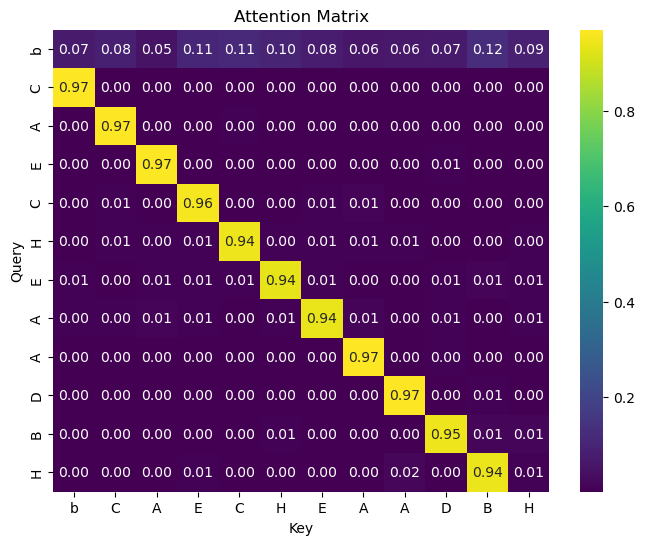

In [74]:
display_matrix(Att1, string_seq)

In [75]:
R = D//2

In [76]:
def second_layer(Z, beta=1):
    K_2 = np.zeros((D, D), dtype=np.float32)
    #K_2[:D//2, D//2:] = np.eye(D//2)  
    K_2[:R, D//2:D//2+R] = np.eye(R)  
    Att2 = Z @(K_2) @ (Z.T) *100
    Att2 = softmax(Att2, axis=1)
    V2 = beta* np.eye(D)
    Z2 = (Att2 @ Z @ V2)/np.linalg.norm(Att2 @ Z)
    return Att2, Z2


In [77]:
Att2, Z2 = second_layer(Z1)

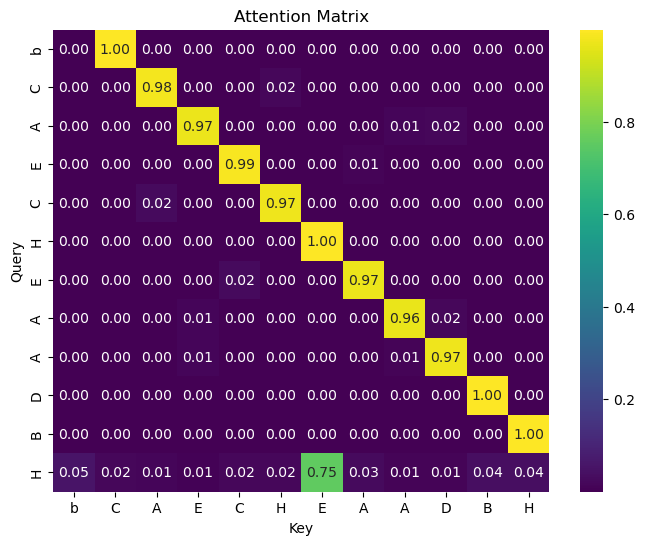

In [78]:
display_matrix(Att2, string_seq)

In [79]:
def classification(k, dico, Z):
    mlp = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        mlp[i] = dico[key] *30
    logits = mlp @ Z[-1].T
    return softmax(logits)
    

In [80]:
classification_result = classification(k, dic, Z2)
print("Classification result", classification_result)

Classification result [0.01837427 0.02476838 0.02109711 0.018208   0.46929316 0.01492679
 0.01721303 0.03091643 0.02047259 0.01664684 0.02512747 0.01839036
 0.03157238 0.02643331 0.01690673 0.01721228 0.0195073  0.02246863
 0.01701928 0.02612717 0.02470289 0.02568543 0.02209789 0.01631955
 0.01954069 0.01897205]


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

def plot_output(output, k):
    letters = list(string.ascii_uppercase[:k])
    df = pd.DataFrame({'Lettre': letters, 'Probabilité': output})

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x='Lettre', y='Probabilité')
    plt.title("Distribution des probabilités (softmax)")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()


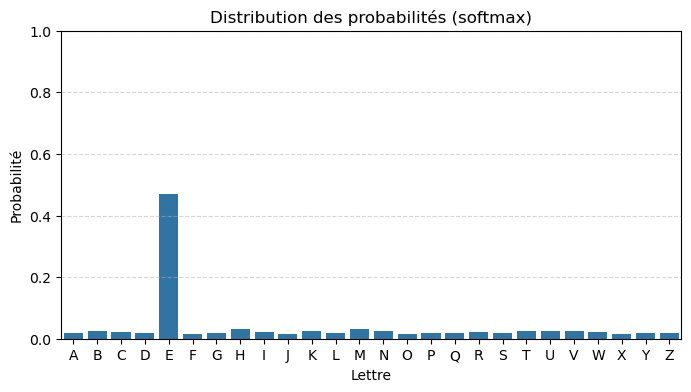

In [82]:
plot_output(classification_result, k)

In [83]:
def generate_X_y(T, dico, n):
    """
    Génère n séquences (X, y) :
    - X est une séquence de T+1 lettres : 'b', ..., target (qui apparaît deux fois)
    - y est la lettre juste après la première apparition du target
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 3, "T doit être au moins 3 pour que target puisse apparaître avant la fin et être suivi"

    X_list = []
    y_list = []

    for _ in range(n):
        seq = []
        target = random.choice(letters)

        # Position du target dans le corps, garanti < T - 1
        insert_pos = random.randint(0, T - 2)

        middle_letters = []
        for i in range(0, T):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        seq.extend(middle_letters)
        seq.append(target)  # target en dernière position

        y = middle_letters[insert_pos+1]
        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [84]:
X, y = generate_X_y(T, dic, 1)
X, y

([['Y', 'O', 'M', 'P', 'I', 'F', 'L', 'V', 'O', 'Z', 'J', 'Q', 'F']], ['L'])

In [85]:
def model(S):
    Att1, Z1 = first_layer(P, S)
    Att2, Z2 = second_layer(Z1)
    logits = classification(k, dic, Z2)
    return logits

In [86]:
P.shape, string_to_token(string_seq).shape

((12, 1000), (12, 1000))

In [87]:
model(string_to_token(string_seq))

array([0.01837427, 0.02476838, 0.02109711, 0.018208  , 0.46929316,
       0.01492679, 0.01721303, 0.03091643, 0.02047259, 0.01664684,
       0.02512747, 0.01839036, 0.03157238, 0.02643331, 0.01690673,
       0.01721228, 0.0195073 , 0.02246863, 0.01701928, 0.02612717,
       0.02470289, 0.02568543, 0.02209789, 0.01631955, 0.01954069,
       0.01897205])

In [88]:
import numpy as np

def display_predictions_numpy(X_seq, y_true, model, char_to_int, int_to_char):
    """
    X_seq : liste de séquences de lettres (n x (T+1))
    y_true : liste de lettres (n)
    model  : fonction prenant S (n, T+1) indices → logits (n, k)
    Retourne l'affichage coloré dans le terminal.
    """
    error = 0
    BLUE  = '\033[94m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

    # Conversion une fois des séquences en indices
    S_list = [string_to_token(x) for x in X_seq]  # shape (n, T+1)

    for i, S in enumerate(S_list):
        logits = model(S)             # shape (1, k) ou (k,)
        # si model renvoie (1,k), on aplatit :
        logits = logits.flatten()
        y_pred_idx = np.argmax(logits)
        pred_letter = int_to_char[y_pred_idx+1]
        true_letter = y_true[i]

        x_letters = X_seq[i]
        last = x_letters[-1]
        # trouver position unique de last dans le préfixe (sans compter b)
        other_pos = next(j for j, c in enumerate(x_letters[0:-1], start=0) if c == last)

        # marquer la séquence
        colored = []
        for j, c in enumerate(x_letters[1:], start=1):  # on ignore le 'b' à j=0
            if j == other_pos or j == len(x_letters)-1:
                # soit la première occurrence du last, soit la dernière
                colored.append(f"{BLUE}{c}{RESET}")
            elif c == true_letter:
                colored.append(f"{GREEN}{c}{RESET}")
            else:
                colored.append(c)

        print(f"Sequence : {''.join(colored)}")
        print(f"  True : {GREEN}{true_letter}{RESET}, Predicted : {GREEN}{pred_letter}{RESET}")

        # compter les erreurs
        if logits.max() < 0.5 or pred_letter != true_letter:
            error += 1

    print(f"\nErreur : {error} / {len(X_seq)} séquences")


In [89]:
T=10
X_seq, y = generate_X_y(T=T, dico=dic, n=30)


In [90]:
char_to_int = {c: i for i, c in enumerate(dic)}
int_to_char = {i: c for c, i in char_to_int.items()}


display_predictions_numpy(X_seq[:30], y, model, char_to_int, int_to_char)


Sequence : FMTPUBNWTN
  True : W, Predicted : W
Sequence : OIYKJAYJPO
  True : I, Predicted : I


Sequence : HSQGTBNHQS
  True : Q, Predicted : Q
Sequence : ETXNLQIRYX
  True : N, Predicted : N
Sequence : AUTDUGYSOG
  True : Y, Predicted : Y
Sequence : IBLVRDJKCK
  True : C, Predicted : C
Sequence : PNQUPAMZJN
  True : Q, Predicted : Q
Sequence : KSHSQTCKWN
  True : K, Predicted : K
Sequence : OBOYQPDJAD
  True : J, Predicted : J
Sequence : UKBEZVQPWQ
  True : P, Predicted : P
Sequence : SAZMGJLCSV
  True : S, Predicted : S
Sequence : CUBOTJUVHB
  True : O, Predicted : O
Sequence : MBAQWBZPLA
  True : Q, Predicted : Q
Sequence : PCAOLPGBPA
  True : O, Predicted : O
Sequence : BXMRAMEDQD
  True : Q, Predicted : Q
Sequence : VTJUGIMLKU
  True : G, Predicted : G
Sequence : GJQSINUYNS
  True : I, Predicted : I
Sequence : VZONIZFHRV
  True : Z, Predicted : Z
Sequence : EPDIKUQXOZ
  True : E, Predicted : E
Sequence : HEYBBKRGAY
  True : B, Predicted : B
Sequence : MHZNZVELKN
  True : Z, Predicted : Z
Sequence : BQXGJGHTJX
  True : G, Predicted : G
Sequence : UHVNQMVHNU
  True : H, Predic

In [115]:
X_seq, y = generate_X_y(T=T, dico=dic, n=50000)

In [116]:
X_token = [string_to_token(x) for x in X_seq]  # shape (n, T+1)
X_token = np.array(X_token, dtype=np.float32)  # shape (n, T+1, D)
X_token.shape, X_token.dtype

((50000, 11, 1000), dtype('float32'))

In [117]:
y_data = np.array([char_to_int[c]-1 for c in y], dtype=np.int32)  # shape (n,)
y_data

array([ 9, 13, 25, ...,  7, 16, 10], dtype=int32)

In [118]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn

In [119]:

class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.beta = nn.Parameter(torch.ones(1))
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage

        attn_output = self.beta * torch.matmul(attn_weights, V)
        return self.norm(attn_output + x)


In [120]:
class AttentionOnlyTransformer(nn.Module):
    def __init__(self, d_model=2000, nhead=1, num_layers=2, num_classes=26, max_len=11):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, d_model))
        self.blocks = nn.ModuleList([
            AttentionOnlyBlock(d_model) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes, bias=False)

    def forward(self, x):  # x: (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1), :]
        for block in self.blocks:
            x = block(x)
        last_token = x[:, -1, :]  # utiliser la sortie du dernier token
        return self.classifier(last_token)  # (B, num_classes)


In [121]:
X_tensor = torch.tensor(X_token, dtype=torch.float32)  # (30, 11, 2000)
y_tensor = torch.tensor(y_data, dtype=torch.long)  

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=320, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [123]:
def initialize_model(model):
    # classifier
    classifier_layer = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        classifier_layer[i] = dic[key]
    with torch.no_grad():
        model.classifier.weight.copy_(torch.tensor(classifier_layer, dtype=torch.float32))
        model.classifier.weight.requires_grad = False

    # first layer
    P_copy = P[:T+1].copy()
    V1 = permutation_matrix(D)  
    attn_layer1 = model.blocks[0]
    W_k1 = np.eye(D, dtype=np.float32)
    W_v1 = V1.astype(np.float32)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, len(P)):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    W_q1 = QK1.astype(np.float32).T *100
    with torch.no_grad():
        #attn_layer1.Wq.weight.data.copy_(torch.tensor(W_q1))
        attn_layer1.Wk.weight.data.copy_(torch.tensor(W_k1))
        attn_layer1.Wv.weight.data.copy_(torch.tensor(W_v1))
        attn_layer1.Wv.weight.requires_grad = False
        #attn_layer1.Wq.weight.requires_grad = False
        attn_layer1.Wk.weight.requires_grad = False
    
    # second layer
    K_2 = np.zeros((D, D), dtype=np.float32)
    #K_2[:D//2, D//2:] = np.eye(D//2)  
    K_2[:R, D//2:D//2+R] = np.eye(R)
    K_2 = K_2.astype(np.float32)
    Q_2 = np.eye(D, dtype=np.float32)
    V2 = np.eye(D, dtype=np.float32)
    attn_layer2 = model.blocks[1]
    W_q2 = Q_2.astype(np.float32)
    W_k2 = K_2.astype(np.float32)
    W_v2 = V2.astype(np.float32)
    with torch.no_grad():
        attn_layer2.Wq.weight.data.copy_(torch.tensor(W_q2))
        #attn_layer2.Wk.weight.data.copy_(torch.tensor(W_k2))
        attn_layer2.Wv.weight.data.copy_(torch.tensor(W_v2))
        attn_layer2.Wv.weight.requires_grad = False
        attn_layer2.Wq.weight.requires_grad = False
        #attn_layer2.Wk.weight.requires_grad = False
    
    # positionnal encoding
    with torch.no_grad():
        # Initialiser les poids de la couche d'attention avec P_copy
        model.positional_encoding.copy_(torch.tensor(P_copy.reshape(1, T+1, D), dtype=torch.float32))
        model.positional_encoding.requires_grad = False

    # beta
    with torch.no_grad():
        model.blocks[0].beta.copy_(torch.tensor(1.0, dtype=torch.float32))
        model.blocks[1].beta.copy_(torch.tensor(1.31, dtype=torch.float32))
        model.blocks[0].beta.requires_grad = False
        model.blocks[1].beta.requires_grad = False

    #printing the model parameters
    for name, param in model.named_parameters():
        if param.requires_grad:...
            #print(name, param.shape)


In [124]:
model = AttentionOnlyTransformer(d_model=D, nhead=1, num_layers=2, num_classes=k, max_len=T+1)


In [125]:
initialize_model(model)

In [126]:
from torch.utils.data import Subset

def get_subset_dataset(train_dataset, D, alpha, shuffle=True):
    num_samples = int(D * alpha)
    print(f"Num samples: {num_samples}")
    indices = torch.randperm(len(train_dataset))[:num_samples] if shuffle else torch.arange(num_samples)
    subset = Subset(train_dataset, indices)
    return subset


In [127]:
import time

In [128]:
def train_model(model, train_loader, criterion, optimizer, D, alpha, num_epochs=10):
    train_subdataset = get_subset_dataset(train_loader.dataset, D, alpha)
    train_loader = DataLoader(train_subdataset, batch_size=32, shuffle=True)
    print(len(train_loader))
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        # ---------- Entraînement ----------
        train_time = time.time()

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)  # (B, 27)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct += (outputs.argmax(dim=1) == yb).sum().item()
            total += xb.size(0)

        train_acc = correct / total
        train_loss = total_loss / total
        train_time = time.time() - train_time
        #print(f"Training time: {train_time:.2f} seconds")

        # ---------- Évaluation ----------
        model.eval()
        test_time = time.time()
        with torch.no_grad():
            xb, yb = next(iter(test_loader))
            outputs = model(xb)
            test_loss = criterion(outputs, yb).item()
            test_acc = (outputs.argmax(dim=1) == yb).float().mean().item()
        test_time = time.time() - test_time
        #print(f"Test time: {test_time:.2f} seconds")
        if epoch % (num_epochs//50) == 0:
            print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
            #print(f"Beta : {model.blocks[1].beta.item()}")
    return model, train_loss, train_acc, test_acc


In [129]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [131]:
train_model(model, train_loader, criterion, optimizer, D=D, alpha=50, num_epochs=50)

Num samples: 50000
1250
Epoch 00 | Train Loss: 3.7448 | Train Acc: 0.0755 | Test Acc: 0.0700
Epoch 01 | Train Loss: 3.1875 | Train Acc: 0.1360 | Test Acc: 0.0900
Epoch 02 | Train Loss: 3.0451 | Train Acc: 0.2373 | Test Acc: 0.4100
Epoch 03 | Train Loss: 1.4678 | Train Acc: 0.7510 | Test Acc: 0.8500
Epoch 04 | Train Loss: 0.2667 | Train Acc: 0.9788 | Test Acc: 1.0000
Epoch 05 | Train Loss: 0.0781 | Train Acc: 0.9971 | Test Acc: 1.0000
Epoch 06 | Train Loss: 0.0521 | Train Acc: 0.9979 | Test Acc: 1.0000


KeyboardInterrupt: 

In [ ]:
def experiment(alphas):
    results = []
    for a in alphas:
        alpha = a*2
        print(f"Experiment with alpha: {alpha}")
        model = AttentionOnlyTransformer(d_model=D, nhead=1, num_layers=2, num_classes=k, max_len=T+1)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        initialize_model(model)
        model, train_loss, train_acc, test_acc = train_model(model, train_loader, criterion, optimizer, D=D, alpha=alpha, num_epochs=int(25/alpha+50))
        results.append((alpha, model, train_loss, train_acc, test_acc))
    return results

In [ ]:
alphas = [0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 4]
results = experiment(alphas)

Experiment with alpha: 0.01
Num samples: 10
1
Epoch 00 | Train Loss: 16.8932 | Train Acc: 0.0000 | Test Acc: 0.0000
Epoch 51 | Train Loss: 8.8800 | Train Acc: 0.0000 | Test Acc: 0.0000
Epoch 102 | Train Loss: 1.0820 | Train Acc: 0.9000 | Test Acc: 0.0100
Epoch 153 | Train Loss: 0.1076 | Train Acc: 1.0000 | Test Acc: 0.0100
Epoch 204 | Train Loss: 0.0664 | Train Acc: 1.0000 | Test Acc: 0.0100


KeyboardInterrupt: 

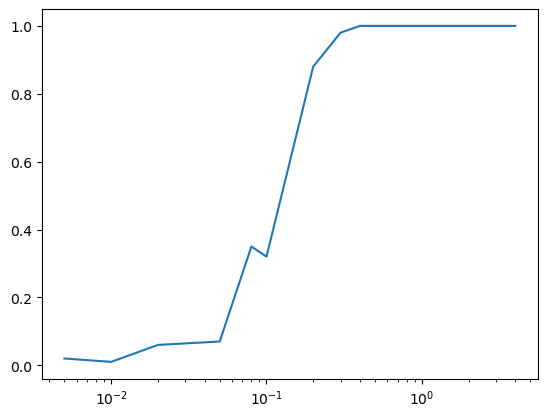

In [ ]:
plt.plot(alphas, [r[4] for r in results], label='Test accuracy')
# log x axis
plt.xscale('log')

In [159]:
begin = 0
end = 10
X_plot = X_tensor[:end, begin:]
y_plot = y_tensor[:end]

len:11
Sequence : ['E', 'I', 'A', 'N', 'G', 'I', 'S', 'J', 'A', 'D', 'S']
  True : J, Predicted : J
0 0
0 1
len:11
Sequence : ['C', 'B', 'C', 'G', 'T', 'L', 'I', 'B', 'Z', 'N', 'Z']
  True : N, Predicted : N
1 0
1 1
len:11
Sequence : ['N', 'X', 'E', 'O', 'Z', 'H', 'B', 'N', 'X', 'G', 'O']
  True : Z, Predicted : Z
2 0
2 1
len:11
Sequence : ['J', 'A', 'N', 'F', 'V', 'G', 'V', 'T', 'M', 'N', 'M']
  True : N, Predicted : N
3 0
3 1
len:11
Sequence : ['L', 'G', 'M', 'S', 'T', 'T', 'Q', 'Q', 'M', 'F', 'S']
  True : T, Predicted : T
4 0
4 1
len:11
Sequence : ['K', 'P', 'W', 'J', 'G', 'N', 'E', 'D', 'D', 'Y', 'E']
  True : D, Predicted : D
5 0
5 1
len:11
Sequence : ['T', 'J', 'C', 'A', 'P', 'W', 'G', 'A', 'Z', 'M', 'W']
  True : G, Predicted : G
6 0
6 1
len:11
Sequence : ['X', 'R', 'H', 'Y', 'Q', 'R', 'B', 'T', 'B', 'I', 'H']
  True : Y, Predicted : Y
7 0
7 1
len:11
Sequence : ['B', 'T', 'G', 'Y', 'S', 'E', 'G', 'Y', 'N', 'R', 'S']
  True : E, Predicted : E
8 0
8 1
len:11
Sequence : ['E', 'N',

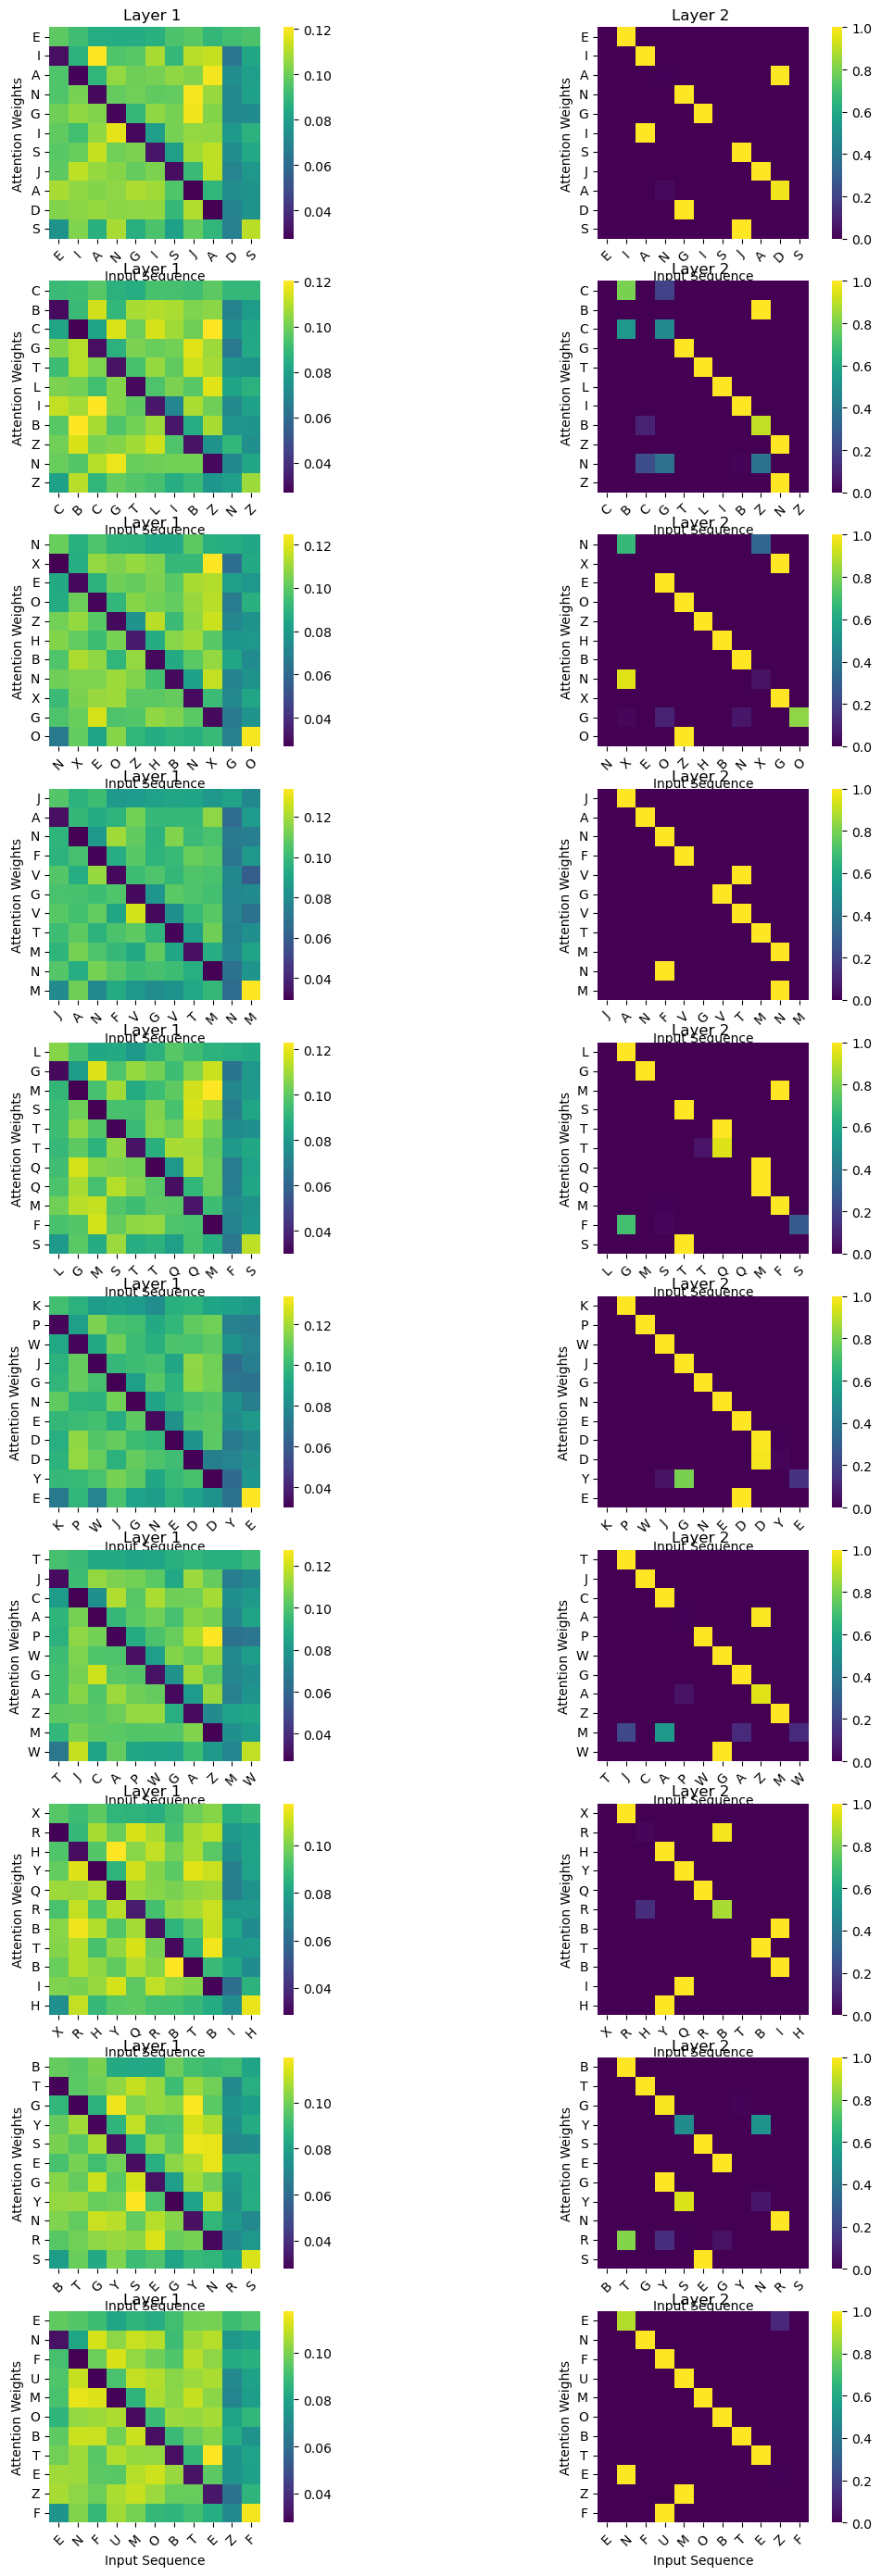

In [161]:
def plot_attention_matrix(model, X_plot, y_plot, char_to_int, int_to_char):
    model.eval()
    num_sequences = len(X_plot) 
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))
    with torch.no_grad():

        for i in range(len(X_plot)):
            attn_weights = []
            x = X_plot[i:i+1]
            print(f"len:{len(x[0])}")
            y = y_plot[i:i+1]

            logits = model(x)
            pred_idx = logits.argmax(dim=1).item()
            pred_letter = int_to_char[pred_idx+1]
            true_letter = int_to_char[y.item()+1]

            print(f"Sequence : {X_seq[i]}")
            print(f"  True : {true_letter}, Predicted : {pred_letter}")
            
            for j in range(len(model.blocks)):
                attn_weights.append(model.blocks[j].attn_weights)

            for j, attn in enumerate(attn_weights):
                print(i,j)
                sns.heatmap(attn[0].cpu().numpy(), cmap="viridis",
                            xticklabels=X_seq[i][begin:],
                            yticklabels=X_seq[i][begin:], ax=axs[i, j],
                            square=True)
                axs[i][j].set_title(f"Layer {j + 1} ")
                axs[i][j].set_xlabel("Input Sequence")
                axs[i][j].set_ylabel("Attention Weights")
                axs[i][j].set_xticklabels(X_seq[i][begin:], rotation=45)
                axs[i][j].set_yticklabels(X_seq[i][begin:], rotation=0)
    return fig

fig = plot_attention_matrix(model, X_plot, y_plot, char_to_int, int_to_char)

In [162]:
fig.savefig("subdiagonal_without_attention.png", dpi=300, bbox_inches='tight')